# Project 2 - Trading Meme Stocks

## Imports, environment variables and keys 

In [133]:
import requests
import os
import pandas as pd
import numpy as np
import time
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


In [2]:
# Load environment variables
load_dotenv()

#Set API Key from env variable
ss_key=os.getenv("SS_API_KEY")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

## Helper Functions

In [3]:
def get_sentiment_df():
    # Create headers variable containing API Key 
    headers = {
        'Authorization' : f'Token {ss_key}',
        'Accept': 'application/json',
    }

    sentiment_response = requests.get('https://socialsentiment.io/api/v1/stocks/sentiment/daily/', headers=headers)
    sentiment_dict = sentiment_response.json()['results']
    sentiment_df = pd.DataFrame.from_dict(sentiment_dict)
    line_count = sentiment_response.json()['count']
    page_count = int(line_count / 50) + (line_count % 50 > 0)
    page=2

    while page <= page_count:
        # Loop through all pages available from API and construct dataframe for sentiment data
        sentiment_url = "https://socialsentiment.io/api/v1/stocks/sentiment/daily/?page=%s"%page
        sentiment_response = requests.get(sentiment_url, headers=headers)
        sentiment_dict = sentiment_response.json()['results']
        sentiment_df_loop = pd.json_normalize(sentiment_dict)
        sentiment_df = pd.concat([sentiment_df, sentiment_df_loop], axis=0)
        page += 1
        time.sleep(1)

    sentiment_df.reset_index(inplace=True, drop=True)
    path = (f'../Resources/sentiment_{date.today()}.csv')
    sentiment_df.to_csv(path)
    return sentiment_df

In [4]:
def get_sentiment_trending_df():
    headers = {
        'Authorization' : f'Token {ss_key}',
        'Accept': 'application/json',
    }
    trending_response = requests.get('https://socialsentiment.io/api/v1/stocks/trending/daily/', headers=headers)
    trending_dict = trending_response.json()
    trending_df = pd.DataFrame.from_dict(trending_dict)
    path = (f'../Resources/sentiment_trending_{date.today()}.csv')
    trending_df.to_csv(path)
    return trending_df

## Fundemental Analysis

In [5]:
sentiment_df = get_sentiment_df()
sentiment_df.head()

,stock,date,score,positive_score,negative_score,activity,avg_7_days,avg_14_days,avg_30_days
0,AAL,2022-03-07,5,19,-12,5,2,3,1
1,AAPL,2022-03-07,5,15,0,17,-2,-15,-5
2,ABNB,2022-03-07,7,18,-10,11,0,-2,1
3,APPH,2022-03-07,19,19,0,1,10,7,8
4,AUD,2022-03-07,-16,0,-16,1,-21,-19,-7


In [6]:
sentiment_trending_df = get_sentiment_trending_df()
sentiment_trending_df.head()

,stock,score,positive_score,negative_score,activity,activity_avg_7_days,activity_avg_14_days,activity_avg_30_days,score_avg_7_days,score_avg_14_days,score_avg_30_days
0,CVX,73,82,-58,19448,7982,4858,12417,-2,-1,-4
1,XOM,77,82,-36,19121,11567,6326,12738,-18,-12,-7
2,MCO,-19,35,-70,11906,2827,2128,1128,-30,-21,-11
3,PFE,-35,43,-49,4041,20882,14992,18333,-38,-28,-5
4,BLK,33,58,-34,2545,2095,1947,3451,-8,-11,-8


These functions return 2 data frames with useful data. Need to discuss as a team what we target as our metrics. 

For example it could be any of the following
1. Top 10 stocks with highest overall sentiment score
2. Top 10 most improved sentiment
3. Top 10 positive sentiment
4. Greated jump in sentiment from long to short term

In [18]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
stock_name = pd.DataFrame(sentiment_df['stock'])
stock_name.head(3)

,stock
0,AAL
1,AAPL
2,ABNB


In [22]:
#Prepare Data
X = sentiment_df.set_index("stock").drop(columns="date")
X.head(3)

,score,positive_score,negative_score,activity,avg_7_days,avg_14_days,avg_30_days
stock,,,,,,,
AAL,5,19,-12,5,2,3,1
AAPL,5,15,0,17,-2,-15,-5
ABNB,7,18,-10,11,0,-2,1


In [24]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)
X_scaled[0:5]

array([[-0.25584179,  0.9381996 , -1.29414087, -0.12840955, -0.34439074,
        -0.23633881, -0.91100454],
       [-0.25584179,  0.37865639,  0.52549962,  0.73094664, -0.84065565,
        -2.56405317, -1.80656832],
       [-0.04830579,  0.7983138 , -0.99086745,  0.30126855, -0.5925232 ,
        -0.88292614, -0.91100454],
       [ 1.1969102 ,  0.9381996 ,  0.52549962, -0.41486161,  0.64813909,
         0.28093104,  0.13381988],
       [-2.43496979, -1.71963062, -1.9006877 , -0.41486161, -3.197914  ,
        -3.08132303, -2.10508958]])

In [25]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
sentiment_pca = pca.fit_transform(X_scaled)

In [26]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data=sentiment_pca, columns=["PC 1", "PC 2", "PC 3"], index=X.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
stock,,,
AAL,1.089283,0.917375,-0.113436
AAPL,2.448945,0.605970,-1.675285
ABNB,1.420933,1.044644,-0.436217
APPH,-1.370906,0.554016,-0.941966
AUD,5.821495,-1.478562,-0.147795


In [27]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

C:\Users\AdamF\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



:Curve   [k]   (inertia)

In [29]:
# Initialize the K-Means model
model = KMeans(n_clusters=7, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.DataFrame({
    "score": X.score,
    "positive_score": X.positive_score,
    "negative_score": X.negative_score,
    "activity": X.activity,
    "avg_7_days": X.avg_7_days,
    "avg_14_days": X.avg_14_days,
    "avg_30_days": X.avg_30_days,
    "PC 1": pcs_df['PC 1'],
    "PC 2": pcs_df['PC 2'],
    "PC 3": pcs_df['PC 3'],
    "Class": model.labels_,
    },
    index=X.index
)
clustered_df.head()

,score,positive_score,negative_score,activity,avg_7_days,avg_14_days,avg_30_days,PC 1,PC 2,PC 3,Class
stock,,,,,,,,,,,
AAL,5,19,-12,5,2,3,1,1.089283,0.917375,-0.113436,2
AAPL,5,15,0,17,-2,-15,-5,2.448945,0.605970,-1.675285,2
ABNB,7,18,-10,11,0,-2,1,1.420933,1.044644,-0.436217,2
APPH,19,19,0,1,10,7,8,-1.370906,0.554016,-0.941966,3
AUD,-16,0,-16,1,-21,-19,-7,5.821495,-1.478562,-0.147795,5


In [32]:
top_stocks = clustered_df.sort_values("score", ascending=False).head(10)

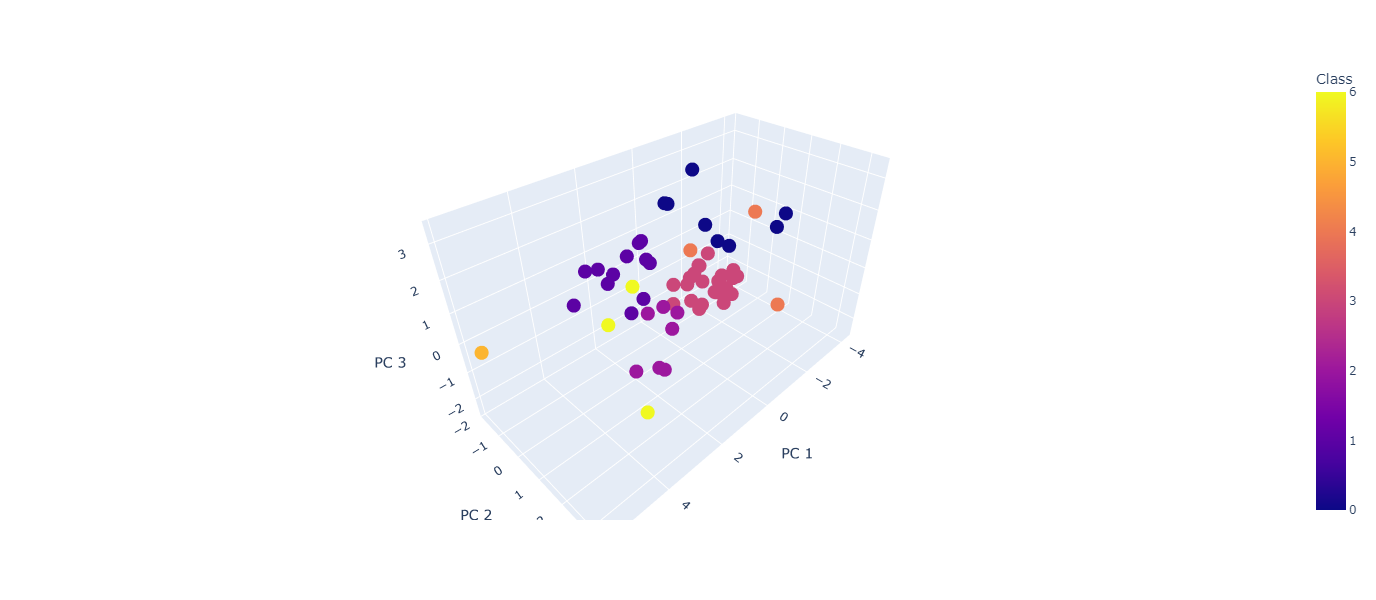

In [31]:
# Plotting the 3D-Scatter with x="PC 1", y="PC 2" and z="PC 3"
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    hover_name='score',
    hover_data= ['activity'],
    height=600,
    color="Class"
)
fig.show()

In [44]:
# Until we decide exatcly what features of the functional analysis we will use, I have proceeded to TA just using top 10 sentiment scores for stocks
top_class = top_stocks["Class"].mode()
top_class_stocks = top_stocks.loc[top_stocks["Class"] == top_class[0]]
top_class_stocks

,score,positive_score,negative_score,activity,avg_7_days,avg_14_days,avg_30_days,PC 1,PC 2,PC 3,Class
stock,,,,,,,,,,,
ING,20,20,0,1,6,8,8,-1.261351,0.641002,-1.150329,3
DISCK,20,20,0,2,10,8,9,-1.553963,0.709077,-0.917601,3
THO,19,19,0,1,6,9,12,-1.534036,0.492037,-0.780117,3
NTZ,19,19,0,1,7,11,14,-1.855678,0.479570,-0.551416,3
TFII,19,19,0,2,2,10,13,-1.419239,0.494738,-0.811211,3
SB,19,19,0,1,11,14,10,-2.009996,0.519757,-0.535655,3
APPH,19,19,0,1,10,7,8,-1.370906,0.554016,-0.941966,3
PENN,18,18,0,1,10,11,14,-1.969861,0.380598,-0.344949,3


## Technical Analysis

In [47]:
# Create the Alpaca API object, specifying use of the paper trading account:
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url = 'https://paper-api.alpaca.markets',
    api_version = "v2"
)

In [201]:
# Get tickers for top class stocks from FA
ticker_list = top_class_stocks.index
#ticker_list = ["GOOG","FB","AAPL","AMZN"]


# declare begin and end date strings
beg_date = '2022-03-04'
end_date = '2022-03-04'
# we convert begin and end date to formats that the ALPACA API requires
start =  pd.Timestamp(f'{beg_date} 09:30:00-0400', tz='America/New_York').replace(hour=9, minute=30, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
end   =  pd.Timestamp(f'{end_date} 16:00:00-0400', tz='America/New_York').replace(hour=16, minute=0, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
# We set the time frequency at which we want to pull prices
timeframe='1Min'

# Pull prices from the ALPACA API
stocks_ohlcv = api.get_bars(ticker_list, timeframe, start=start, end=end).df

In [202]:
stocks_ohlcv.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-03-04 14:30:00+00:00,3.8800,3.8800,3.80,3.805,73216,365,3.866987,APPH
2022-03-04 14:31:00+00:00,3.7900,3.8400,3.79,3.840,902,7,3.803368,APPH
2022-03-04 14:32:00+00:00,3.8250,3.8250,3.81,3.810,1989,37,3.812745,APPH
2022-03-04 14:33:00+00:00,3.8200,3.8200,3.79,3.790,5385,7,3.817943,APPH
2022-03-04 14:34:00+00:00,3.8255,3.8255,3.80,3.810,7299,22,3.821197,APPH


In [203]:
stocks_ohlcv.tail()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-03-04 20:56:00+00:00,87.520,87.60,87.48,87.56,9676,153,87.537684,THO
2022-03-04 20:57:00+00:00,87.570,87.69,87.56,87.67,5463,104,87.600627,THO
2022-03-04 20:58:00+00:00,87.665,87.73,87.63,87.72,13898,235,87.673951,THO
2022-03-04 20:59:00+00:00,87.710,87.87,87.71,87.73,19638,330,87.779964,THO
2022-03-04 21:00:00+00:00,87.750,87.75,87.75,87.75,31990,13,87.750000,THO


In [204]:
ticker_list

Index(['ING', 'DISCK', 'THO', 'NTZ', 'TFII', 'SB', 'APPH', 'PENN'], dtype='object', name='stock')

In [205]:
close_df = pd.DataFrame(index=stocks_ohlcv.index)

for ticker in ticker_list:
    vector = stocks_ohlcv.loc[stocks_ohlcv["symbol"] == ticker].close
    close_df[ticker] = vector

close_df.dropna(axis=1, how='all', inplace=True)

# Use Pandas' forward fill function to fill missing values (be sure to set inplace=True)
close_df.ffill(inplace=True)
close_df.tail(5)

,ING,DISCK,THO,NTZ,TFII,SB,APPH,PENN
timestamp,,,,,,,,
2022-03-04 20:56:00+00:00,9.695,26.825,87.56,9.99,103.01,4.28,4.5000,46.365
2022-03-04 20:57:00+00:00,9.705,26.810,87.67,10.07,103.02,4.28,4.4981,46.355
2022-03-04 20:58:00+00:00,9.705,26.810,87.72,10.28,103.10,4.28,4.5000,46.370
2022-03-04 20:59:00+00:00,9.715,26.810,87.73,10.28,103.25,4.26,4.4900,46.350
2022-03-04 21:00:00+00:00,9.720,26.810,87.75,10.28,103.25,4.27,4.5000,46.350


In [206]:
# Define a variable to set prediction period
forecast = 1

# Compute the pct_change for 1 min 
returns = close_df.pct_change(periods=forecast)

# Shift the returns to convert them to forward returns
returns = returns.shift(-(forecast))

returns.dropna(inplace=True)

In [207]:
path = (f'../Resources/returns{date.today()}.csv')
returns.to_csv(path)

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='timestamp'>

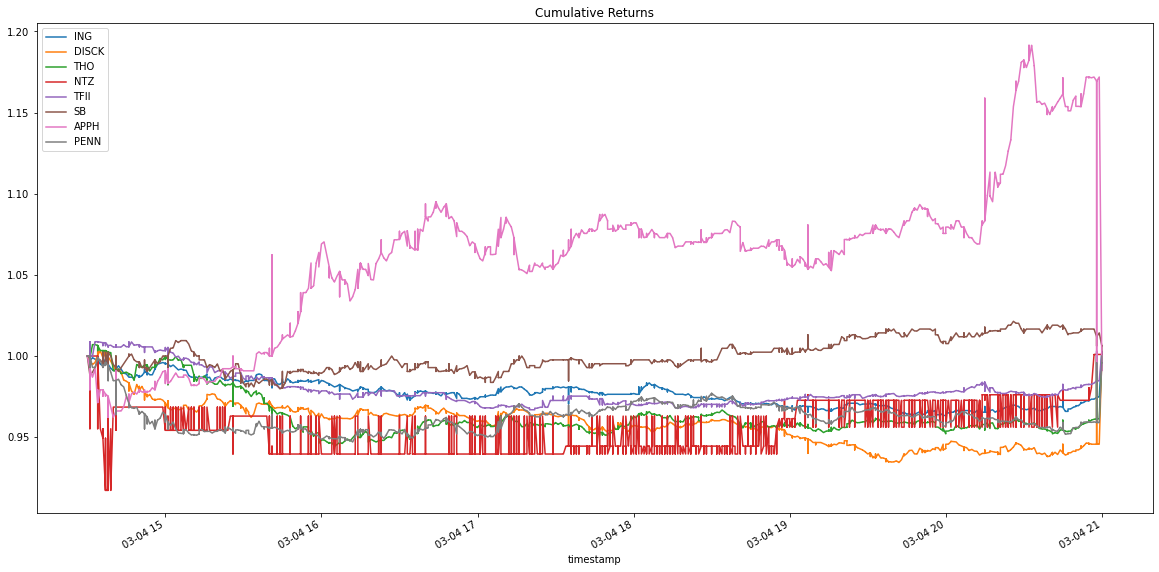

In [208]:
#Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod()

#Plot cumulative returns
cumulative_returns.plot(figsize=(20,10), title = "Cumulative Returns")

In [180]:
def plot_ema(stock):
    stock_close = close_df[stock].to_frame()
  
    # calculating exponential moving average
    stock_close["EMA7"] = ta.ema(stock_close[stock], length=7)
    stock_close["EMA14"] = ta.ema(stock_close[stock], length=14)
    stock_close["EMA21"] = ta.ema(stock_close[stock], length=21)
 
    
    # removing all the NULL values using 
    # dropna() method
    stock_close.dropna(inplace=True)

    
    # plotting Close price and exponential 
    # moving averages of 30 days
    # using .plot() method
    plot = stock_close[[stock, 'EMA7', 'EMA14', 'EMA21']].plot(label='EMAs',
                                   figsize=(40, 20))
    return plot

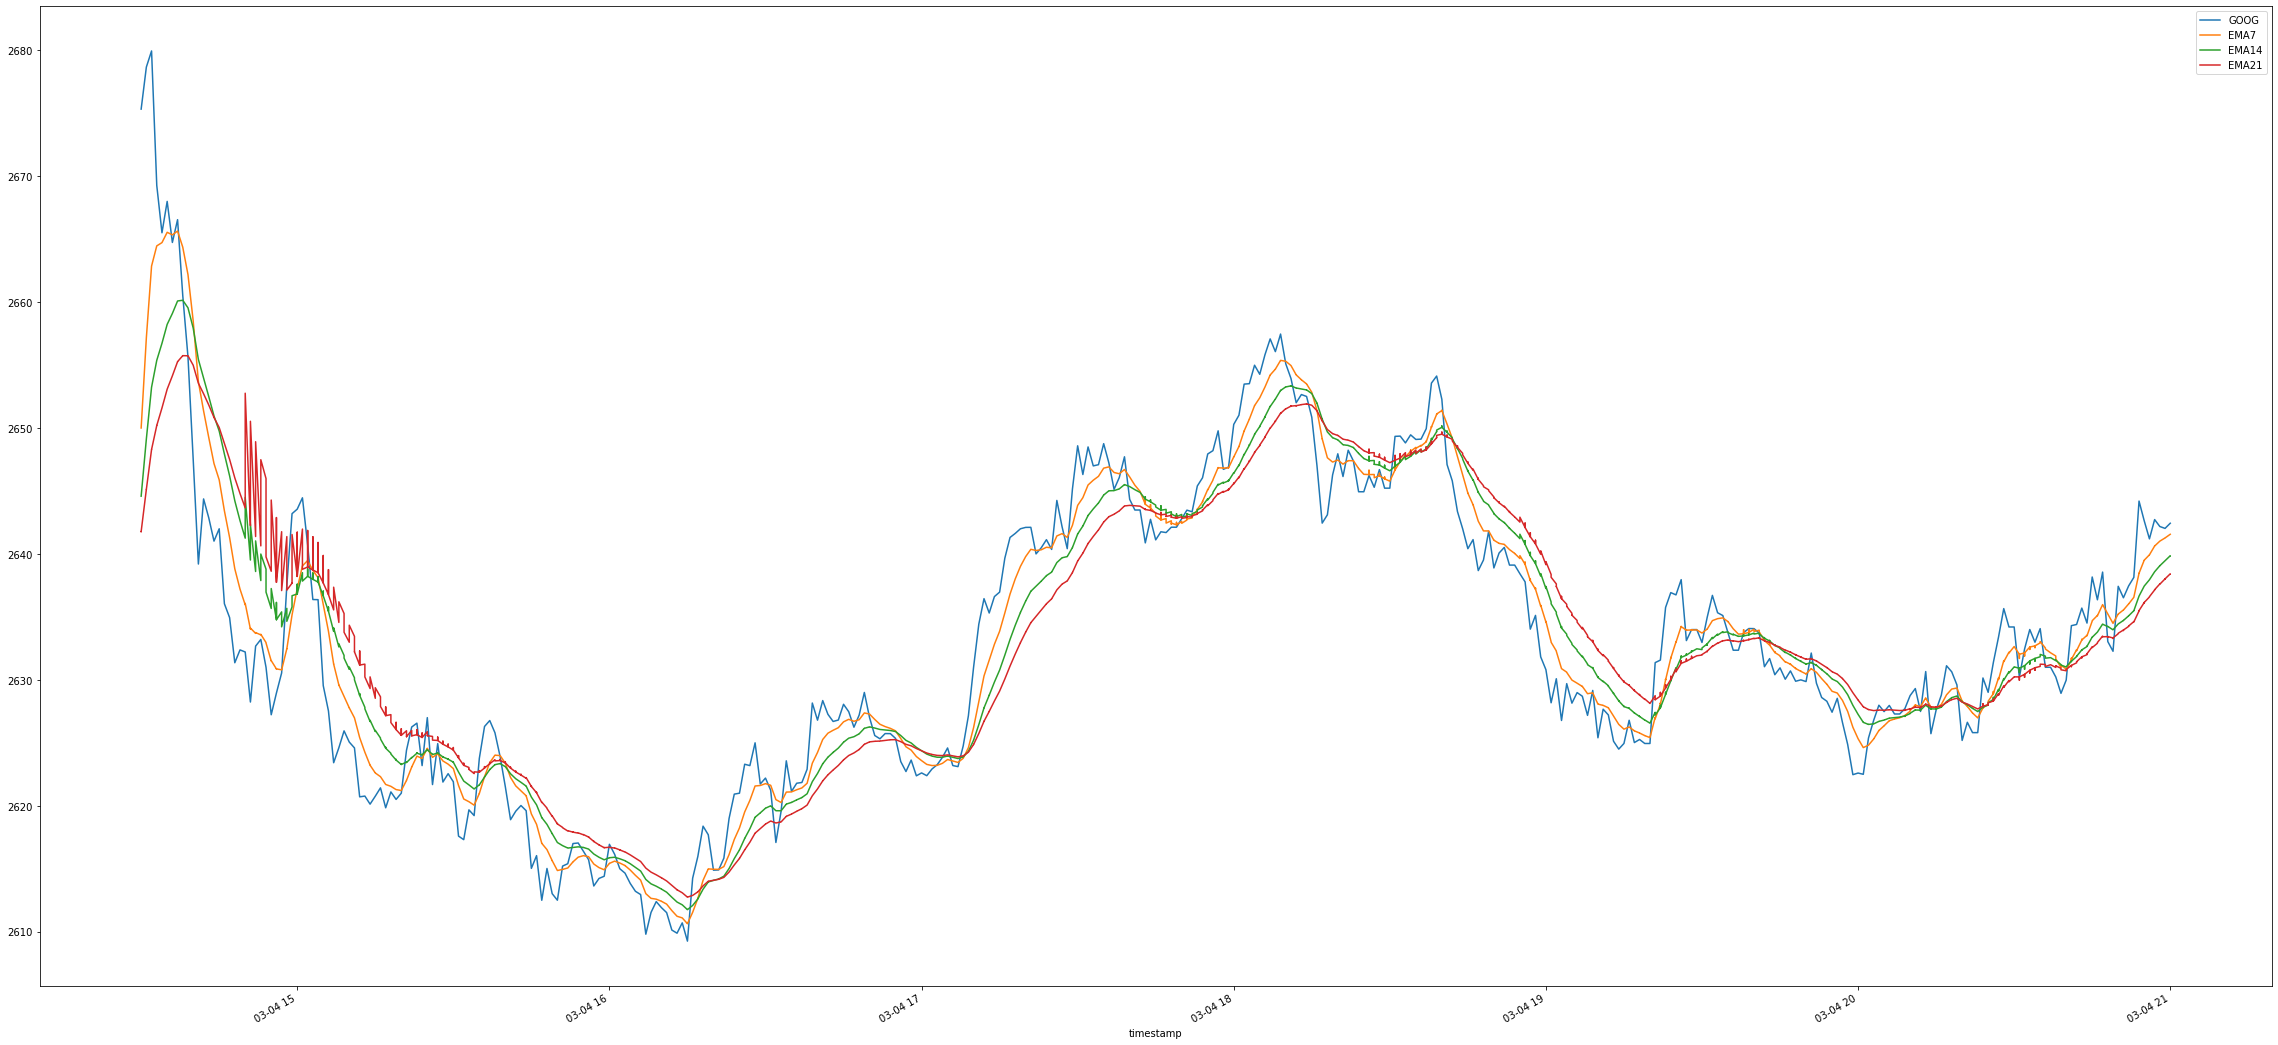

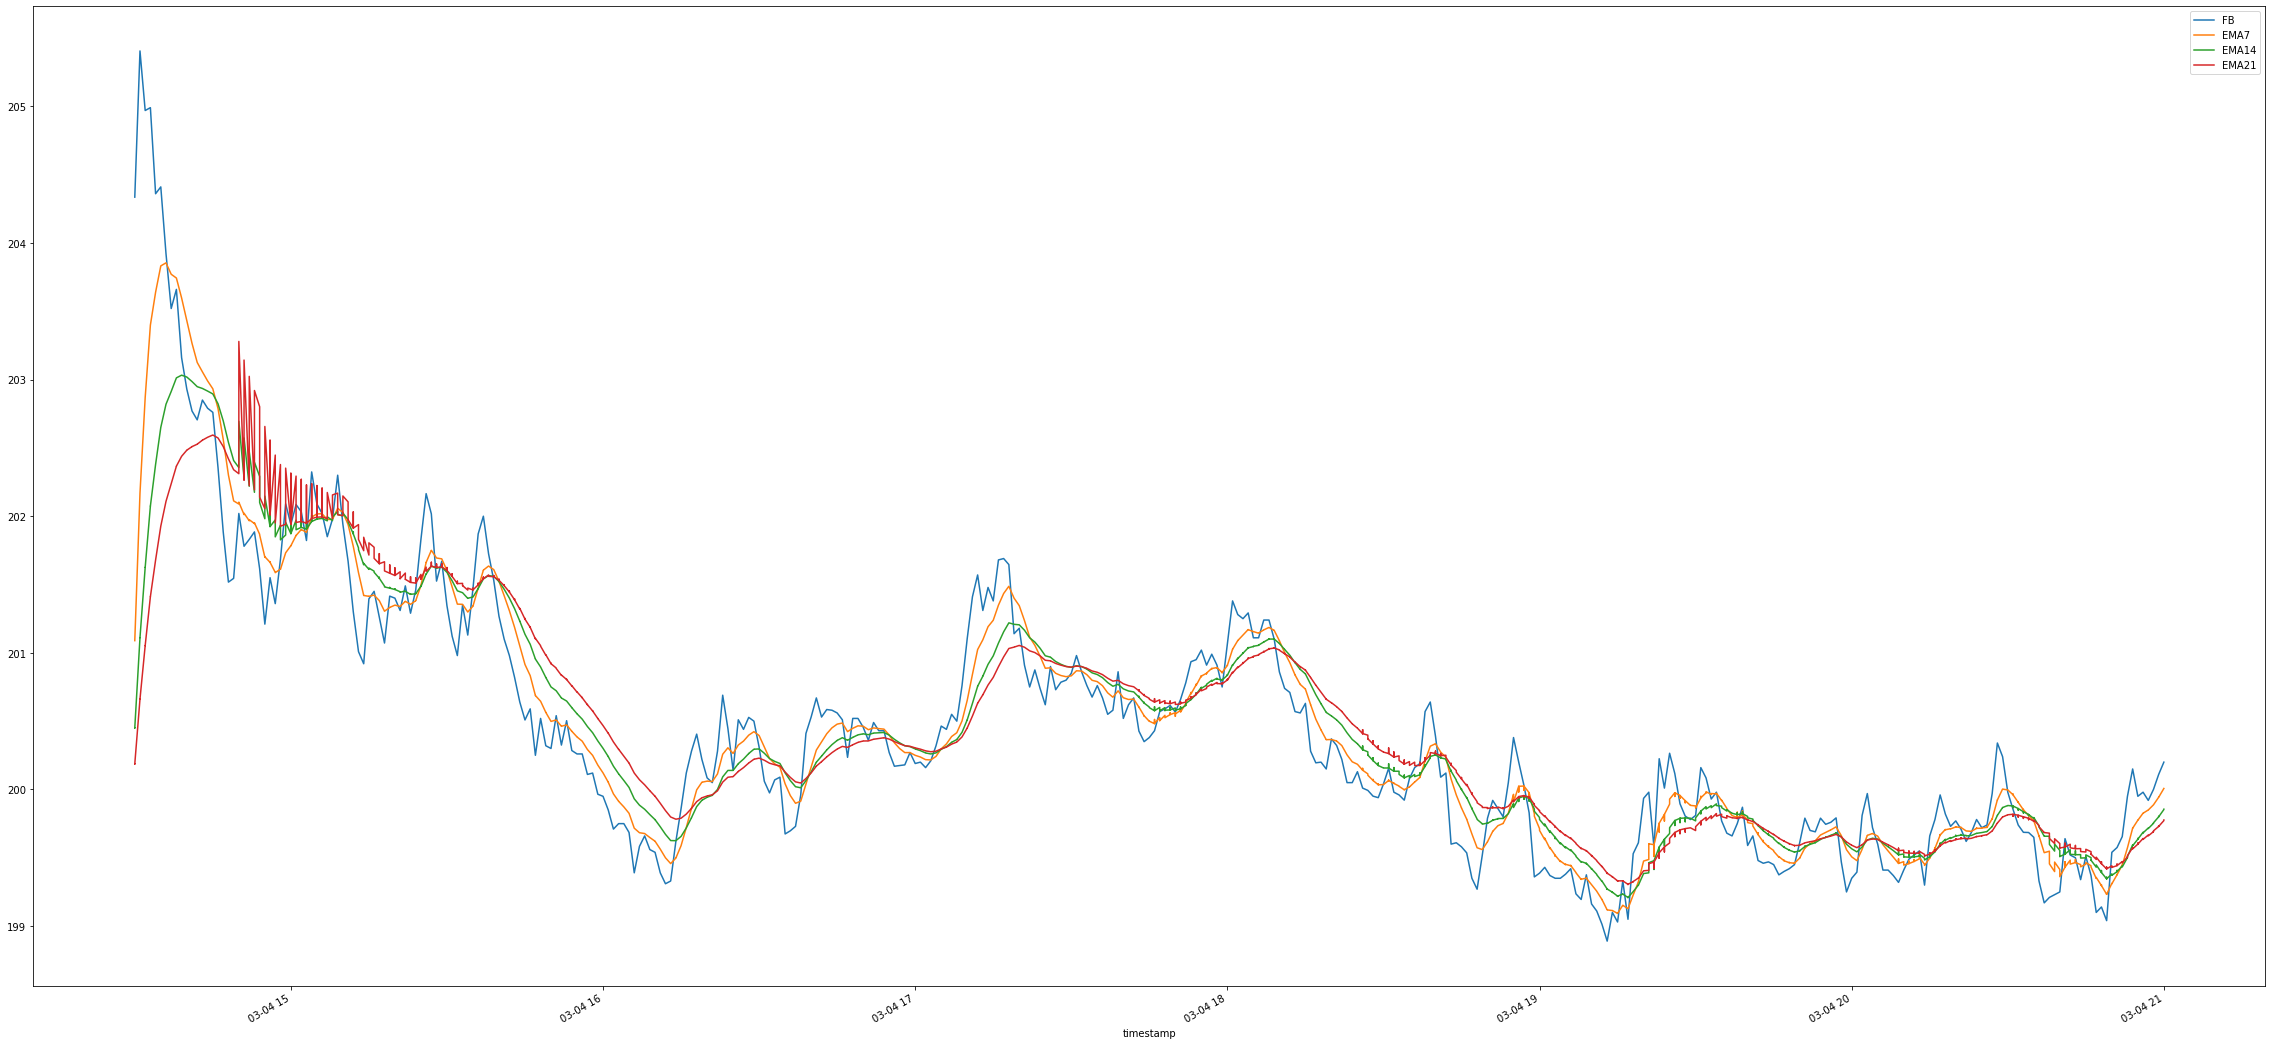

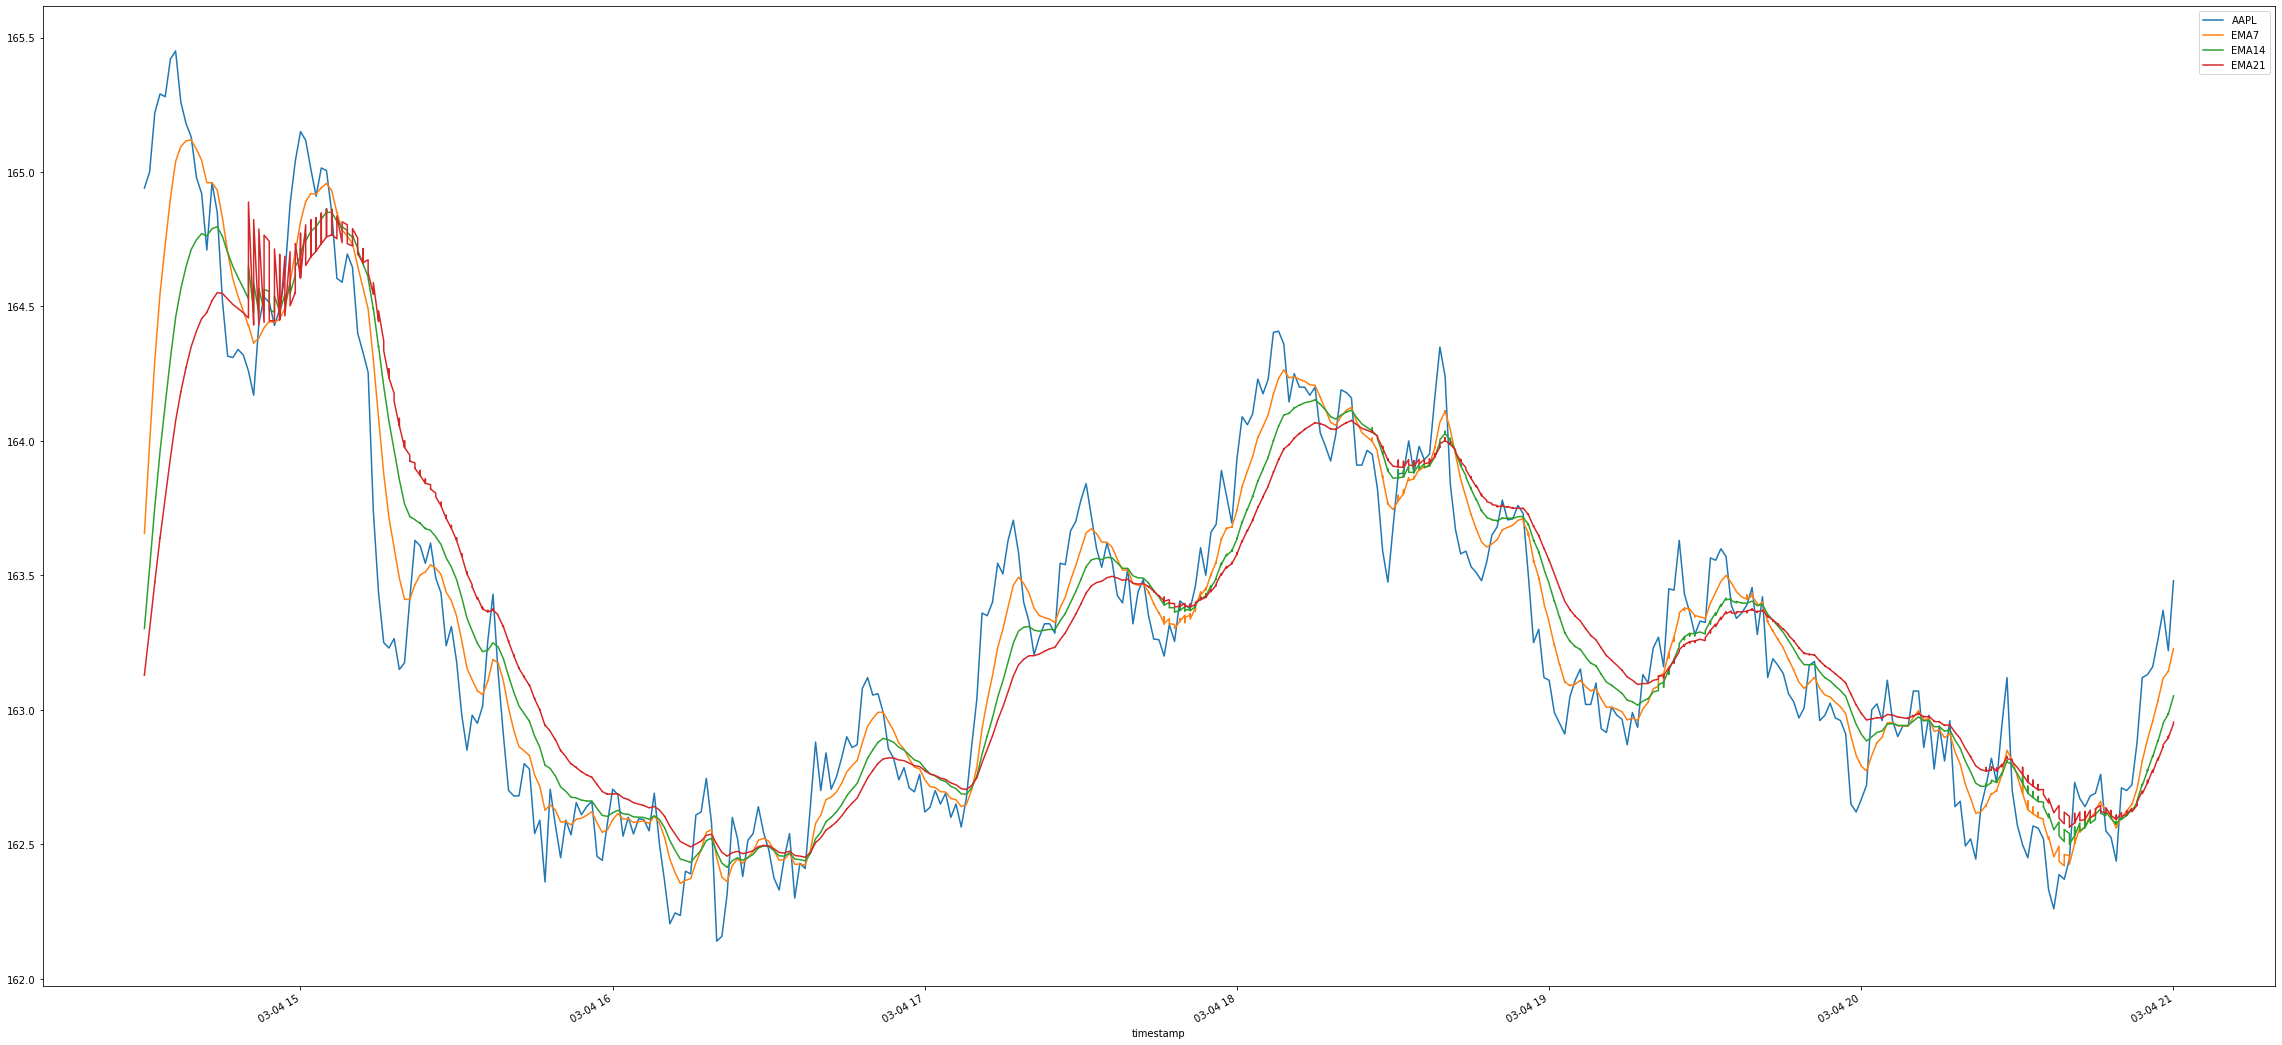

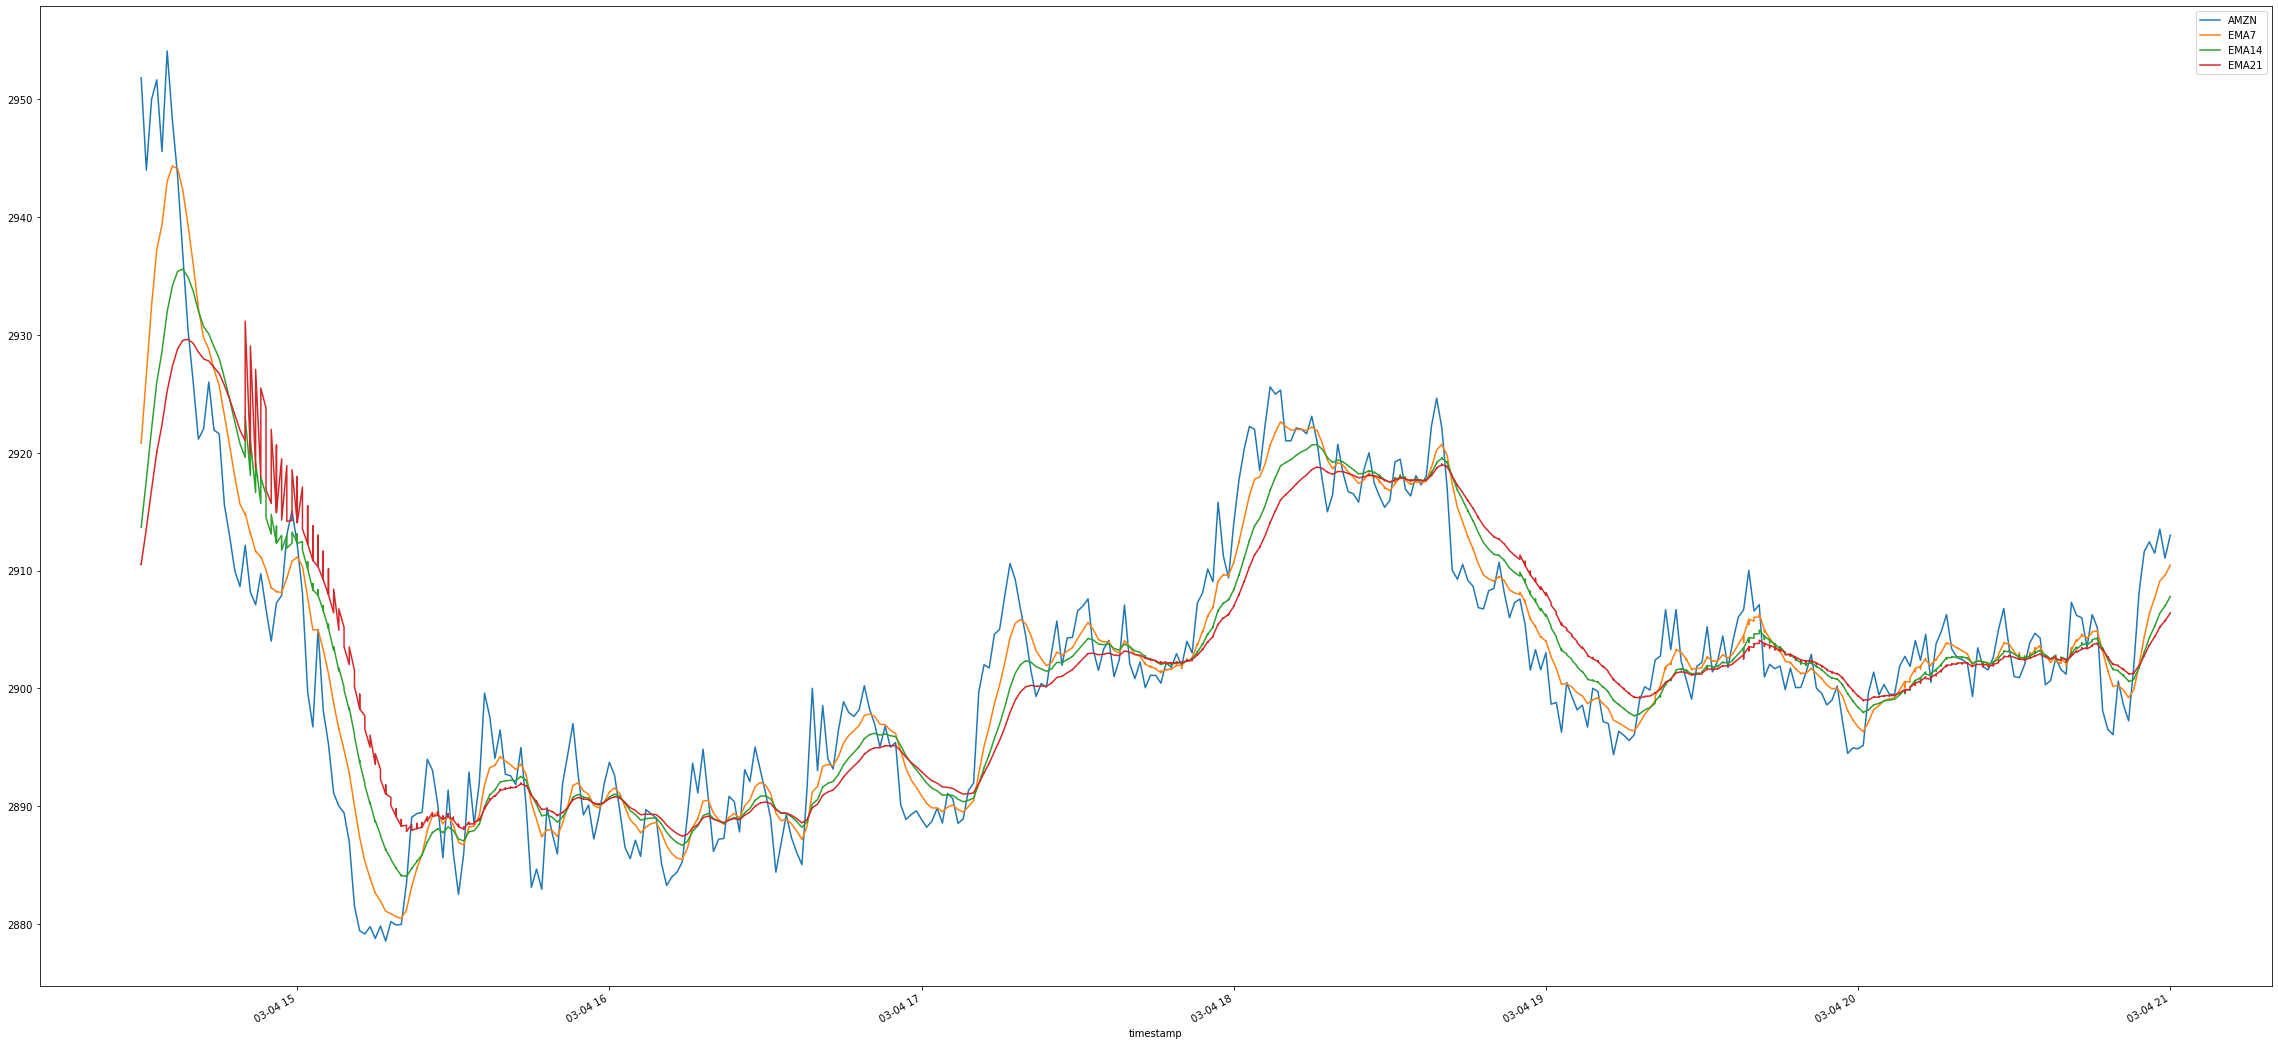

In [181]:
for stock in close_df:
    plot_ema(stock)

In [197]:
returns.head(1)

,GOOG,FB,AAPL,AMZN
timestamp,,,,
2022-03-04 14:30:00+00:00,0.001248,0.005236,0.000364,-0.002656


In [182]:
# Use unstack() to bring the data in long format and save the output as as dataframe
unstack_returns = pd.DataFrame(returns.unstack(level=0))

# Rename the column to make it easer to identify it:
name = f'F_{forecast}_m_returns'
unstack_returns.rename(columns={0: name}, inplace = True)

# Reset the index of the dataframe for merging later (be sure to set inplace=True)
unstack_returns.reset_index(inplace=True)

unstack_returns["EMA15"] = ta.ema(unstack_returns["F_1_m_returns"], length=15)
unstack_returns["EMA30"] = ta.ema(unstack_returns["F_1_m_returns"], length=30)
unstack_returns["EMA45"] = ta.ema(unstack_returns["F_1_m_returns"], length=45)

# Use dropna() to get rid of those missing observations.
unstack_returns.dropna(inplace=True)

# Create a multi index based on level_0 and time
unstack_returns.set_index(['level_0','timestamp'], inplace=True)

In [183]:
unstack_returns.head()    
path = (f'../Resources/unstack_returns{date.today()}.csv')
unstack_returns.to_csv(path)

## Create the Target Set and Split the Data into Training and Testing Sets

In [184]:
# Create a separate dataframe for features and define the target variable as a binary target
X = unstack_returns.iloc[:,1:4]

# Create the target variable
y = []

# Loop through the returns["F_1_m_returns"] data and append 0 or 1 to y based on returns
for row in unstack_returns["F_1_m_returns"]:
    if row > 0:
        y.append(1)

    elif row <= 0:
        y.append(0)

In [185]:
X.head()


EMA15     EMA30     EMA45
level_0 timestamp                                              
GOOG    2022-03-04 15:14:00+00:00 -0.000309 -0.000456 -0.000457
        2022-03-04 15:15:00+00:00 -0.000239 -0.000410 -0.000426
        2022-03-04 15:16:00+00:00 -0.000284 -0.000422 -0.000434
        2022-03-04 15:17:00+00:00 -0.000189 -0.000364 -0.000394
        2022-03-04 15:18:00+00:00 -0.000193 -0.000355 -0.000387

In [196]:
X.tail()

EMA15     EMA30     EMA45
level_0 timestamp                                              
AMZN    2022-03-04 20:55:00+00:00  0.000406  0.000218  0.000149
        2022-03-04 20:56:00+00:00  0.000314  0.000182  0.000128
        2022-03-04 20:57:00+00:00  0.000362  0.000216  0.000153
        2022-03-04 20:58:00+00:00  0.000211  0.000147  0.000110
        2022-03-04 20:59:00+00:00  0.000269  0.000181  0.000134

In [187]:
# Split the dataset without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=False)

In [188]:
# Use Counter to count the number 1s and 0 in y_train
Counter(y_train)

Counter({1: 2179, 0: 2438})

In [189]:
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## Machine Learning

#### RandomForestClassifier

In [190]:
# Create a RandomForestClassifier model and train it on the X_resampled data we created before
rfc_model = RandomForestClassifier()
rfc_model.fit(X_resampled, y_resampled)  

# Use the model you trained to predict using X_test
y_pred = rfc_model.predict(X_test)   

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred, digits=4))

# Print out a balanced accuracy score report to evaluate performance
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Calculate Sharpe Ratio
sharpe_ratio = y_pred.mean() / y_pred.std()
print(f"Sharpe Ratio: {sharpe_ratio}")

              precision    recall  f1-score   support

           0     0.6406    0.6691    0.6545       807
           1     0.6164    0.5861    0.6008       732

    accuracy                         0.6296      1539
   macro avg     0.6285    0.6276    0.6277      1539
weighted avg     0.6291    0.6296    0.6290      1539

Balanced Accuracy Score: 0.6276052775915657
Sharpe Ratio: 0.9086378683505941


#### GradientBoostingClassifier

In [191]:
# Create a GradientBoostingClassifier model and train it on the X_resampled data we created before
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_resampled, y_resampled)  

# Use the model you trained to predict using X_test
y_pred = gbc_model.predict(X_test)   

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred, digits=4))

# Print out a balanced accuracy score report to evaluate performance
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Calculate Sharpe Ratio
sharpe_ratio = y_pred.mean() / y_pred.std()
print(f"Sharpe Ratio: {sharpe_ratio}")

              precision    recall  f1-score   support

           0     0.7022    0.6691    0.6853       807
           1     0.6532    0.6872    0.6698       732

    accuracy                         0.6777      1539
   macro avg     0.6777    0.6782    0.6775      1539
weighted avg     0.6789    0.6777    0.6779      1539

Balanced Accuracy Score: 0.6781517256789973
Sharpe Ratio: 1.000649983819035


#### AdaBoostClassifier

In [192]:
# Create a AdaBoostClassifier model and train it on the X_resampled data we created before
abc_model = AdaBoostClassifier()
abc_model.fit(X_resampled, y_resampled)  

# Use the model you trained to predict using X_test
y_pred = abc_model.predict(X_test)   

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred, digits=4))

# Print out a balanced accuracy score report to evaluate performance
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Calculate Sharpe Ratio
sharpe_ratio = y_pred.mean() / y_pred.std()
print(f"Sharpe Ratio: {sharpe_ratio}")

              precision    recall  f1-score   support

           0     0.7061    0.6580    0.6812       807
           1     0.6493    0.6981    0.6728       732

    accuracy                         0.6771      1539
   macro avg     0.6777    0.6780    0.6770      1539
weighted avg     0.6791    0.6771    0.6772      1539

Balanced Accuracy Score: 0.6780399983748756
Sharpe Ratio: 1.0230066242168179


#### XGBClassifier

In [193]:
# Create a XGBClassifier model and train it on the X_resampled data we created before
xgbc_model = XGBClassifier()
xgbc_model.fit(X_resampled, y_resampled)  

# Use the model you trained to predict using X_test
y_pred = xgbc_model.predict(X_test)   

# Print out a classification report to evaluate performance
print(classification_report(y_test, y_pred, digits=4))

# Print out a balanced accuracy score report to evaluate performance
print(balanced_accuracy_score(y_test, y_pred))

# Print out a balanced accuracy score report to evaluate performance
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Calculate Sharpe Ratio
sharpe_ratio = y_pred.mean() / y_pred.std()
print(f"Sharpe Ratio: {sharpe_ratio}")

C:\Users\AdamF\anaconda3\envs\mlenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0     0.6389    0.6753    0.6566       807
           1     0.6181    0.5792    0.5980       732

    accuracy                         0.6296      1539
   macro avg     0.6285    0.6273    0.6273      1539
weighted avg     0.6290    0.6296    0.6288      1539

0.6272878704775835
Balanced Accuracy Score: 0.6272878704775835
Sharpe Ratio: 0.8967833621300075


Implement the strongest model using Apaca API

### Develop the Algorithm


#### 1. Use the provided code to ping the Alpaca API and create the DataFrame needed to feed data into the model.
   * This code will also store the correct feature data in `X` for later use.

In [194]:

# Define Dates
beg_date = '2021-01-06'
end_date = '2021-01-06'

# Convert the date in a format the Alpaca API reqires
start =  pd.Timestamp(f'{beg_date} 09:30:00-0400', tz='America/New_York').replace(hour=9, minute=30, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
end   =  pd.Timestamp(f'{end_date} 16:00:00-0400', tz='America/New_York').replace(hour=15, minute=0, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
timeframe='1Min'

# Use iloc to get the last 10 mins every time we pull new data
prices = api.get_barset(ticker_list, "minute", start=start, end=end).df.iloc[-11:]
prices.ffill(inplace=True)   

close_df = pd.DataFrame(index=stocks_ohlcv.index)

for ticker in ticker_list:
    vector = stocks_ohlcv.loc[stocks_ohlcv["symbol"] == ticker].close
    close_df[ticker] = vector

close_df.dropna(axis=1, how='all', inplace=True)

# Use Pandas' forward fill function to fill missing values (be sure to set inplace=True)
close_df.ffill(inplace=True)
close_df.tail(5)

print(df_closing_prices.head(20))

C:\Users\AdamF\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:11: DeprecatedWarning:

get_barset is deprecated as of v1.0.0. Use get_bars instead



NameError: name 'df_closing_prices' is not defined

In [32]:
# Create list of momentums
list_of_momentums = [1,5,10]

for i in list_of_momentums:  
    # Compute percentage change for each one of the momentums in the momentum list
    returns_temp = df_closing_prices.pct_change(i)
    # Unstack the returns 
    returns_temp = pd.DataFrame(returns_temp.unstack())
    name = f'{i}_m_returns'
    returns_temp.rename(columns={0: name}, inplace = True)
    # Reset the index so we can merge based on index
    returns_temp.reset_index(inplace = True)
    # Merge newly computed returns with previously created returns
    if i ==1:
        returns = returns_temp
    else:
        returns = pd.merge(returns,returns_temp,left_on=['level_0', 'time'],right_on=['level_0', 'time'], how='left', suffixes=('_original', 'right'))

# Drop nulls and set index
returns.dropna(axis=0, how='any', inplace=True)
returns.set_index(['level_0', 'time'], inplace=True)

# Generate feature data and preview first 10 rows.
X = returns
X.head(10)

,,1_m_returns,5_m_returns,10_m_returns
level_0,time,,,
FB,2021-01-06 15:00:00-05:00,-0.001960,-0.000151,0.000869
AMZN,2021-01-06 15:00:00-05:00,-0.000717,-0.000555,0.000515
AAPL,2021-01-06 15:00:00-05:00,-0.002345,-0.002267,0.004091
NFLX,2021-01-06 15:00:00-05:00,0.000593,0.000257,-0.000217
GOOGL,2021-01-06 15:00:00-05:00,0.000000,-0.000070,-0.000778
MSFT,2021-01-06 15:00:00-05:00,-0.000770,-0.001213,0.000654
TSLA,2021-01-06 15:00:00-05:00,-0.000735,-0.001587,0.010500


#### 2. Using `joblib`, load the chosen model.

In [33]:
# Load the previously trained and saved model using joblib
model = joblib.load('log_model.pkl')

#### 3. Use the model file to make predicttions:
* Use `predict` on `X` and save this as `y_pred`.
* Convert `y_pred` to a DataFrame, setting the index to the index of `X`.
* Rename the column 0 to 'buy', be sure to set `inplace =True`.

In [34]:
# Use the model file to predict on X
y_pred = model.predict(X)

# Convert y_pred to a dataframe, set the index to the index of X
y_df = pd.DataFrame(y_pred, index=X.index)

# Rename the column 0 to 'buy', be sure to set inplace =True
y_df.rename(columns={0: "buy"}, inplace = True)
y_df

,,buy
level_0,time,
FB,2021-01-06 15:00:00-05:00,1
AMZN,2021-01-06 15:00:00-05:00,1
AAPL,2021-01-06 15:00:00-05:00,1
NFLX,2021-01-06 15:00:00-05:00,0
GOOGL,2021-01-06 15:00:00-05:00,1
MSFT,2021-01-06 15:00:00-05:00,1
TSLA,2021-01-06 15:00:00-05:00,0


#### 4. Filter the stocks where 'buy' is equal to 1, saving the filter as `y_pred`.

In [35]:
# Filter the stocks where 'buy' is equal to 1
y_pred = y_df.loc[y_df["buy"] == 1]
y_pred

,,buy
level_0,time,
FB,2021-01-06 15:00:00-05:00,1
AMZN,2021-01-06 15:00:00-05:00,1
AAPL,2021-01-06 15:00:00-05:00,1
GOOGL,2021-01-06 15:00:00-05:00,1
MSFT,2021-01-06 15:00:00-05:00,1


#### 5. Using the `y_pred` filter, create a dictionary called `buy_dict` and assign 'n' to each Ticker (key value) as a placeholder.

In [36]:
# Create dictionary from y_pred and assign a 'n' to each of them for now as a placeholder.
buy_dict = dict.fromkeys(y_pred.index.get_level_values(0), 'n')
buy_dict

{'FB': 'n', 'AMZN': 'n', 'AAPL': 'n', 'GOOGL': 'n', 'MSFT': 'n'}

#### 6. Obtain the total available equity in your account from the Alpaca API and store in a variable called `total_capital`. You will split the capital equally between all selected stocks per the CIO's request.

In [37]:
# Pull the total available equity in our account from the  Alpaca API
account = api.get_account()
total_capital = float(account.equity)
print(f"Total available capital: {total_capital}")

Total available capital: 100276.92


In [38]:
# Compute capital per stock, divide equity in account by number of stocks
# Use Alpaca API to pull the equity in the account
if len(buy_dict) > 0:
    capital_per_stock = float(total_capital)/ len(buy_dict)
else:
    capital_per_stock = 0
print(f'Capital per stock: {capital_per_stock}')

Capital per stock: 20055.384


#### 7. Use a for-loop to iterate through `buy_dict` to determine the number stocks you need to buy for each ticker.

In [39]:
# Use for loop to iterate through dictionary of buys 
# Determine the number stocks we need to buy for each ticker
for ticker in buy_dict:
    try:
        buy_dict[ticker] = int(capital_per_stock /int(prices[ticker].iloc[-1]['close']))
    except:
        pass

print(buy_dict)

{'FB': 75, 'AMZN': 6, 'AAPL': 157, 'GOOGL': 11, 'MSFT': 93}


#### 8. Cancel all previous orders in the Alpaca API (so you don't buy more than intended) and sell all currently held stocks to close all positions.

In [40]:
# Cancel all previous orders in the Alpaca API
api.cancel_all_orders()

# Sell all currently held stocks to close all positions
api.close_all_positions()

[]

#### 9. Iterate through `buy_dict` and send a buy order for each ticker with their corresponding number of shares.

In [41]:
# Iterate through the buy_dict object and send a buy order for each ticker with a corresponding number of shares:
for stock, qty in buy_dict.items():    
    # Submit a market order to buy shares as described in buy_dict
    api.submit_order(
        symbol=stock,
        qty=qty,
        side='buy',
        type='market',
        time_in_force='gtc',
    )
    print(f'buying {stock} numShares {qty}')
    

buying FB numShares 75
buying AMZN numShares 6
buying AAPL numShares 157
buying GOOGL numShares 11
buying MSFT numShares 93


### Automate the algorithm

#### 1. Make a function called `trade()` that incorporates all of the steps above.

In [42]:
# Add all of the steps conducted above into the function trade
def trade():

    ticker_list = ['FB','AMZN','AAPL','NFLX', 'GOOGL', 'MSFT', 'TSLA']
    # Notice that we remove the start and end variables since we want the latest prices.
    timeframe='1Min'
    # Use iloc to get the last 10 mins every time we pull new data
    prices = api.get_barset(ticker_list, "minute").df.iloc[-11:]
    prices.ffill(inplace=True)   

    # Create and empty DataFrame for closing prices
    df_closing_prices = pd.DataFrame()

    # Fetch the closing prices of our tickers
    df_closing_prices["FB"] = prices["FB"]["close"]
    df_closing_prices["AMZN"] = prices["AMZN"]["close"]
    df_closing_prices["AAPL"] = prices["AAPL"]["close"]
    df_closing_prices["NFLX"] = prices["NFLX"]["close"]
    df_closing_prices["GOOGL"] = prices["GOOGL"]["close"]
    df_closing_prices['MSFT'] = prices['MSFT']["close"]
    df_closing_prices['TSLA'] = prices['TSLA']["close"]
    print(df_closing_prices.head())
    
    # Loop through momentums to build new DataFrame
    list_of_momentums = [1,5,10]
    for i in list_of_momentums:   
        returns_temp = df_closing_prices.pct_change(i)
        returns_temp = pd.DataFrame(returns_temp.unstack())
        name = f'{i}_m_returns'
        returns_temp.rename(columns={0: name}, inplace = True)
        returns_temp.reset_index(inplace = True)
        if i ==1:
            returns = returns_temp
        else:
            returns = pd.merge(returns,returns_temp,left_on=['level_0', 'time'],right_on=['level_0', 'time'], how='left', suffixes=('_original', 'right'))

    # Drop nulls and set index            
    returns.dropna(axis=0, how='any', inplace=True)
    returns.set_index(['level_0', 'time'], inplace=True)

    # Preprocess data for model
    model = joblib.load('log_model.pkl')
    y_pred = model.predict(X)
    y_df = pd.DataFrame(y_pred, index=X.index)
    y_df.rename(columns={0: "buy"}, inplace = True)
    y_pred = y_df.loc[y_df["buy"] == 1]
    
    # Create the `buy_dict` object
    buy_dict = dict.fromkeys(y_pred.index.get_level_values(0), 'n')
    
    # Split capital between stocks and determine buy or sell
    account = api.get_account()
    total_capital = float(account.equity)
    if len(buy_dict) > 0:
        capital_per_stock = float(total_capital)/ len(buy_dict)
    else:
        capital_per_stock = 0
    for ticker in buy_dict:
        try:
            buy_dict[ticker] = int(capital_per_stock /int(prices[ticker].iloc[-1]['close']))
        except:
            pass

    
    # Cancel pending orders and close positions
    api.cancel_all_orders()
    api.close_all_positions()
    
    # Submit orders
    for stock, qty in buy_dict.items():    
        # Submit a market order to buy shares as described in buy_dict
        api.submit_order(
            symbol=stock,
            qty=qty,
            side='buy',
            type='market',
            time_in_force='gtc',
        )
    print(f'buying {stock} numShares {qty}')


#### 2. Import Python's schedule module.

In [43]:
# Import Python's schedule module 
# All imports have been completed at the start of the code

#### 3. Use the "schedule" module to automate the algorithm:
* Clear the schedule with `.clear()`.
* Define a schedule to run the trade function every minute at 5 seconds past the minute mark (e.g. `10:31:05`).
* Use the Alpaca API to check whether the market is open.
* Use run_pending() function inside schedule to execute the schedule you defined while the market is open

In [44]:
# Clear the schedule
schedule.clear()

# Define a schedule to run the trade function every minute at 5 seconds past the minute mark (e.g. 10:31:05)
trade_schedule = schedule.every().minute.at(":05").do(trade)

# Use the Alpaca API to check whether the market is open
clock = api.get_clock()

# Use run_pending() function inside schedule to execute the schedule you defined as long as the market is open
while clock.is_open == True:
    print(f'The market trading widow for {clock.next_open} is open, executing trade function')
    schedule.run_pending()
    time.sleep(1)
else:
    print(f'The market is closed the next open market day will be {clock.next_open}')


The market is closed the next open market day will be 2022-03-01 09:30:00-05:00


In [45]:
# Get Scheduled Jobs
schedule.get_jobs()

[Every 1 minute at 00:00:05 do trade() (last run: [never], next run: 2022-03-01 11:00:05)]